In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import igraph as ig
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from tqdm import tqdm

from src import utils, renormalizable_model, network_properties

## Import graph

Airport dataset
https://ericmjl.github.io/Network-Analysis-Made-Simple/05-casestudies/02-airport/

In [5]:
df = pd.read_csv('data/datasets/passengers.csv')

Take year 2015 and only connections with at least one passenger

In [6]:
df = df[df['YEAR'] == 2015]
df = df[df['PASSENGERS'] > 0]

Inspect the dataframe

In [7]:
df.head()

,id,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
432628,432628,2015,05A,05A,{'Tatonduk Outfitters Limited d/b/a Everts Air...,1.0
432629,432629,2015,05A,ANC,{'Tatonduk Outfitters Limited d/b/a Everts Air...,5.0
432630,432630,2015,05A,ARC,{'Tatonduk Outfitters Limited d/b/a Everts Air...,3.0
432631,432631,2015,05A,CXF,{'Tatonduk Outfitters Limited d/b/a Everts Air...,2.0
432632,432632,2015,05A,FAI,{'Tatonduk Outfitters Limited d/b/a Everts Air...,164.0


Now we make a iGraph graph from the dataset

In [8]:
df_for_graph = df.loc[:,["ORIGIN", "DEST", "PASSENGERS"]]
df_for_graph.rename(columns={"PASSENGERS": "weight"}, inplace=True)
# Numerical reasons - we divide weoghts by 1e6
df_for_graph["weight"] = df_for_graph["weight"]/1e6
original_graph = ig.Graph.DataFrame(df_for_graph, use_vids=False)

We keep only those airports with at least one outgoing and one ingoing passenger

In [9]:
while np.any(np.array(original_graph.strength(weights="weight", mode="out") == 0)) or np.any(np.array(original_graph.strength(weights="weight", mode="in")) == 0):
    zero_out_strengths_indices = np.where(np.array(original_graph.strength(weights="weight", mode="out")) == 0)[0]
    original_graph.delete_vertices(zero_out_strengths_indices)
    zero_in_strengths_indices = np.where(np.array(original_graph.strength(weights="weight", mode="in")) == 0)[0]
    original_graph.delete_vertices(zero_in_strengths_indices)

In [10]:
weighted_adj_matrix = utils.weighted_adj_matrix(original_graph)

num_nodes = original_graph.vcount()
out_strengths = np.sum(weighted_adj_matrix, axis=1)
in_strengths = np.sum(weighted_adj_matrix, axis=0)
strengths = np.stack([out_strengths, in_strengths], axis=1)
num_of_links = np.sum(weighted_adj_matrix > 0)

## Empirical graph inspection

In [111]:
print("Number of vertices: ", original_graph.vcount())
print("Number of edges: ", original_graph.ecount())

Number of vertices:  1021
Number of edges:  19199


### Degree distribution

In [112]:
print("Maximal degree: ", max_degree := max(original_graph.degree()))

Maximal degree:  408


Text(0.5, 1.0, 'Degree distribution')

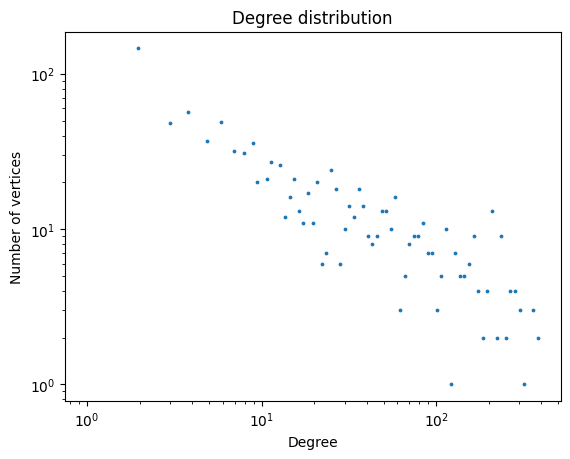

In [113]:
bins = np.logspace(0, np.log10(max_degree), 100)
hist = np.histogram(original_graph.degree(), bins)
plt.scatter(hist[1][:-1], hist[0], s=3)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Degree")
plt.ylabel("Number of vertices")
plt.title("Degree distribution")

### Strength distribution

In [314]:
print("Minimal strength", min_strength := np.min(original_graph.strength(weights="weight", mode="out")))

Minimal strength 1e-06


In [315]:
print("Maximal strength", max_strength := np.max(original_graph.strength(weights="weight", mode="out")))

Maximal strength 44.337603000000016


Text(0, 0.5, 'Number of vertices')

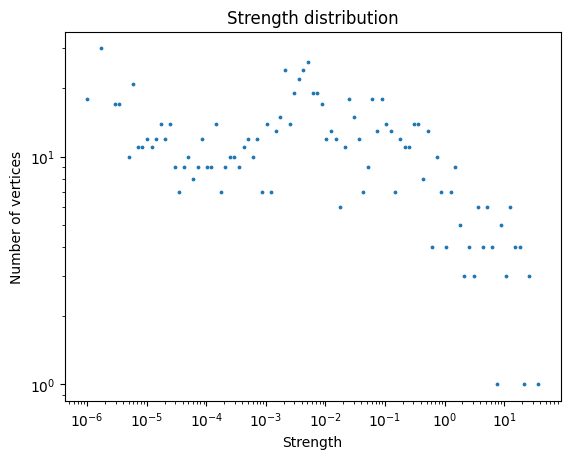

In [116]:
bins = np.logspace(np.log10(min_strength), np.log10(max_strength), 100)
hist = np.histogram(original_graph.strength(weights="weight", mode="out"), bins)
plt.scatter(hist[1][:-1], hist[0], s=3)
plt.yscale("log")
plt.xscale("log")
plt.title("Strength distribution")
plt.xlabel("Strength")
plt.ylabel("Number of vertices")

Text(0, 0.5, 'Number of vertices')

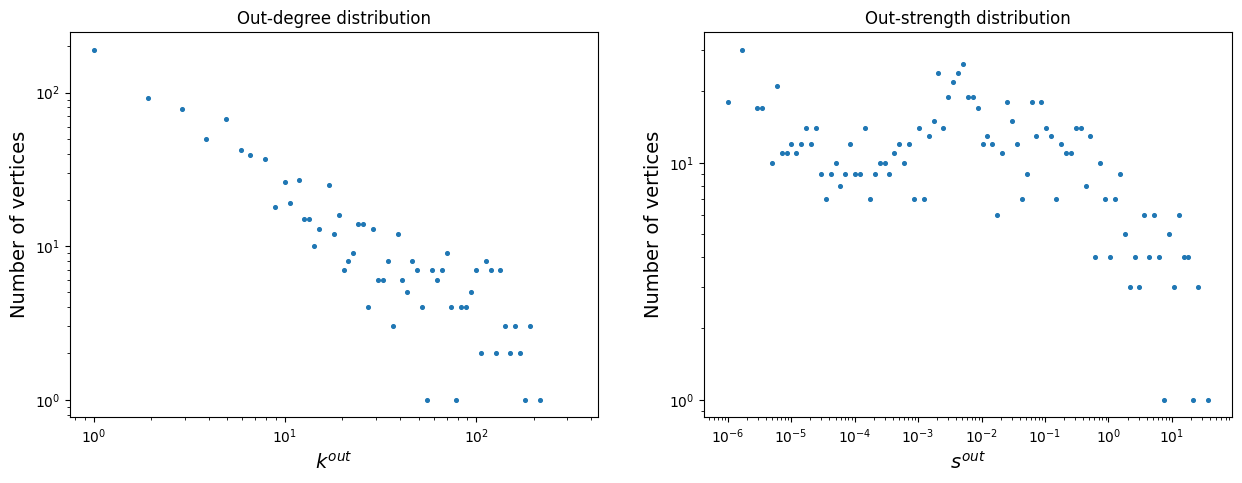

In [317]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

degree_bins = np.logspace(0, np.log10(max_degree), 100)
degree_hist = np.histogram(original_graph.degree(mode="out"), degree_bins)
ax1.scatter(degree_hist[1][:-1], degree_hist[0], s=7)
ax1.set(xscale="log", yscale="log", title="Out-degree distribution")
ax1.set_xlabel("$k^{out}$", fontsize=14)
ax1.set_ylabel("Number of vertices", fontsize=14)

strength_bins = np.logspace(np.log10(min_strength), np.log10(max_strength), 100)
strength_hist = np.histogram(original_graph.strength(weights="weight", mode="out"), strength_bins)
ax2.scatter(strength_hist[1][:-1], strength_hist[0], s=7)
ax2.set(xscale="log", yscale="log", title="Out-strength distribution")
ax2.set_xlabel("$s^{out}$", fontsize=14)
ax2.set_ylabel("Number of vertices", fontsize=14)

# Reconstruction using the original SIM

Estimate the value of z

In [118]:
def exp_num_of_links(strengths, z):
    out_strengths = strengths[:,0]
    in_strengths = strengths[:,1]
    W = np.sum(out_strengths)
    num_nodes = len(out_strengths)
    prob_matrix = np.ones([num_nodes, num_nodes]) - np.exp(-z*out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes))
    return np.sum(prob_matrix)

In [119]:
exp_z_details = scipy.optimize.root_scalar(lambda z: exp_num_of_links(strengths, z) - num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)
exp_z = exp_z_details.root

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.28375012666259636


Check the scale of z\*strength\*strength

In [120]:
print("Maximum:", exp_z*max(out_strengths)*max(in_strengths))

Maximum: 558.5131630498046


In [121]:
print("Mean:", np.mean(exp_z * out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes)))

Mean: 0.136342948959103


Construct the corresponding ensemble using SIM

In [42]:
ensemble_size = 1000
ensemble = renormalizable_model.RMEnsemble()
# ensemble.build_ensemble(ensemble_size, strengths, exp_z, filename = "ensemble_SIM", weighted = True, parallel=False)
ensemble.load_ensemble("ensemble_SIM")

In [123]:
print("Empirical graph number of edges:", num_of_links)
print("Average number of edges is:", np.mean([graph.ecount() for graph in ensemble]))

Empirical graph number of edges: 19199
Average number of edges is: 19198.329


### Comparison of network properties

#### Degrees and strengths

Node by node

In [319]:
exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in ensemble], axis=0)
exp_strengths_out = np.nanmean([graph.strength(mode="out", weights="weight") for graph in ensemble], axis=0)

Text(0, 0.5, '$s^{out}$')

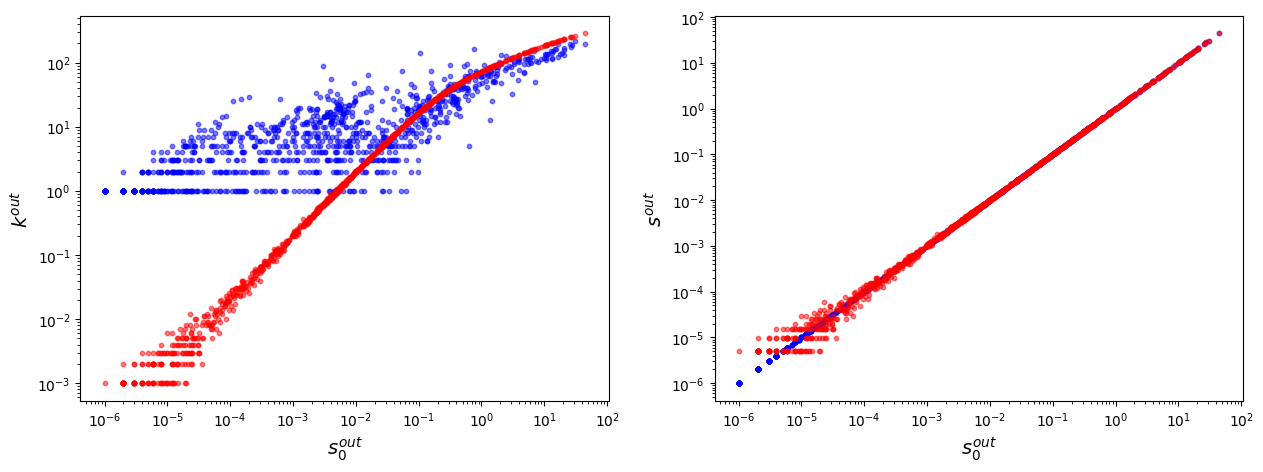

In [320]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")  
ax1.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{out}$", fontsize=14)

ax2.scatter(out_strengths, out_strengths, s=10, c="blue", alpha=.5)
ax2.scatter(out_strengths, exp_strengths_out, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax2.set_ylabel(r"$s^{out}$", fontsize=14)

Histograms

In [321]:
max_degree = np.max([graph.degree() for graph in ensemble])

degree_bins = np.logspace(0, np.log10(max_degree), 100)
degree_histograms_ensemble = [np.histogram(graph.degree(mode="out"), degree_bins)[0] for graph in ensemble]
degree_histogram_empirical = np.histogram(original_graph.degree(mode="out"), degree_bins)[0]

degree_average_histogram = np.mean(degree_histograms_ensemble, axis=0)

In [322]:
max_strength = np.max([graph.strength(weights="weight", mode="out") for graph in ensemble])
min_strength = min(out_strengths)

strength_bins = np.logspace(np.log10(min_strength), np.log10(max_strength), 100)
strength_histograms_ensemble = [np.histogram(graph.strength(weights="weight", mode="out"), strength_bins)[0] for graph in ensemble]
strength_histogram_empirical = np.histogram(out_strengths, strength_bins)[0]

strength_average_histogram = np.nanmean(strength_histograms_ensemble, axis=0)

Text(0, 0.5, 'Number of vertices')

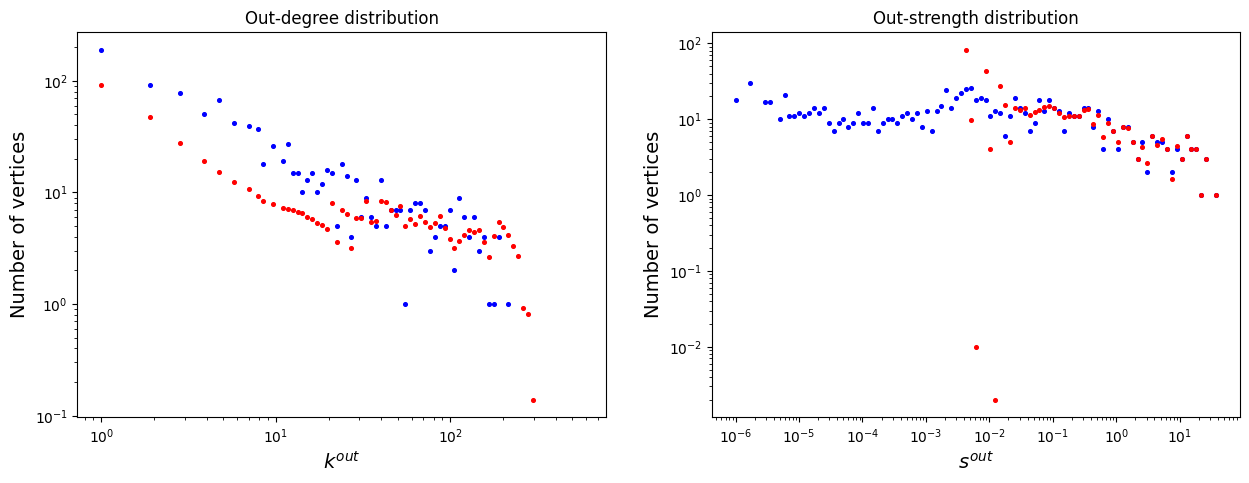

In [324]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(degree_bins[:-1], degree_histogram_empirical, s=7, color="blue")
ax1.scatter(degree_bins[:-1], degree_average_histogram, s=7, color="red")
ax1.set(xscale="log", yscale="log", title="Out-degree distribution")
ax1.set_xlabel("$k^{out}$", fontsize=14)
ax1.set_ylabel("Number of vertices", fontsize=14)

ax2.scatter(strength_bins[:-1], strength_histogram_empirical, s=7, color="blue")
ax2.scatter(strength_bins[:-1], strength_average_histogram, s=7, color="red")
ax2.set(xscale="log", yscale="log", title="Out-strength distribution")
ax2.set_xlabel("$s^{out}$", fontsize=14)
ax2.set_ylabel("Number of vertices", fontsize=14)


### ANND and ANNS

In [40]:
empirical_annd_out = network_properties.annd(original_graph, mode="out")
empirical_anns_out = network_properties.anns(original_graph, mode="out")

In [43]:
exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:30<00:00, 32.72it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_90744/2985335337.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Výzkumný úkol/code/SIM_network_reconstruction/src/network_properties.py:10: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=1)/np.sum(adj_matrix, axis=1)

Text(0, 0.5, '$s^{nn}_{out}$')

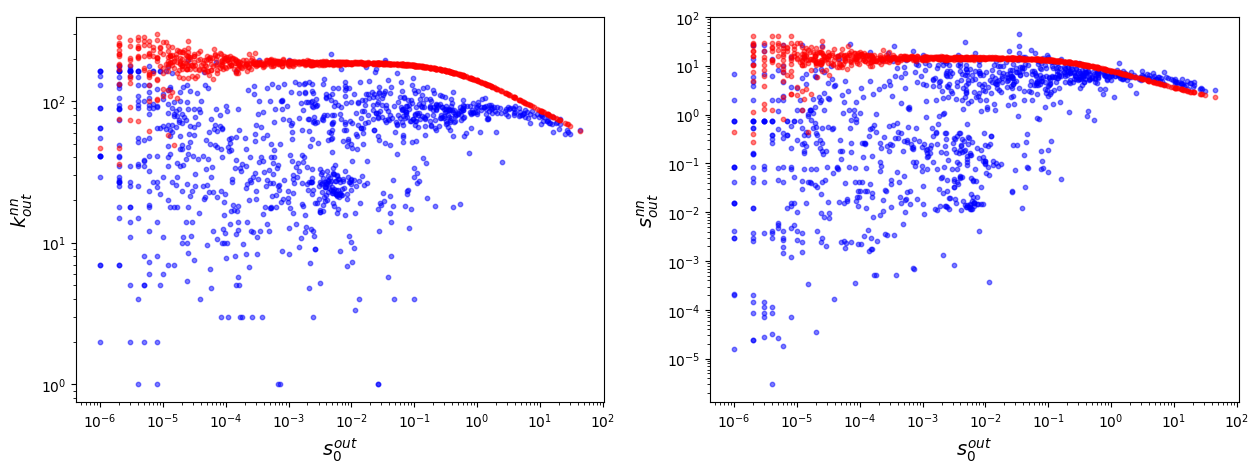

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_annd_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")
ax1.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{nn}_{out}$", fontsize=14)

ax2.scatter(out_strengths, empirical_anns_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_strengths, exp_anns_out, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax2.set_ylabel(r"$s^{nn}_{out}$", fontsize=14)

In [132]:
out_degrees = original_graph.degree(mode="out")

[Text(0.5, 0, '$k^{out}$'), Text(0, 0.5, '$s^{nn}_{out}$'), None, None]

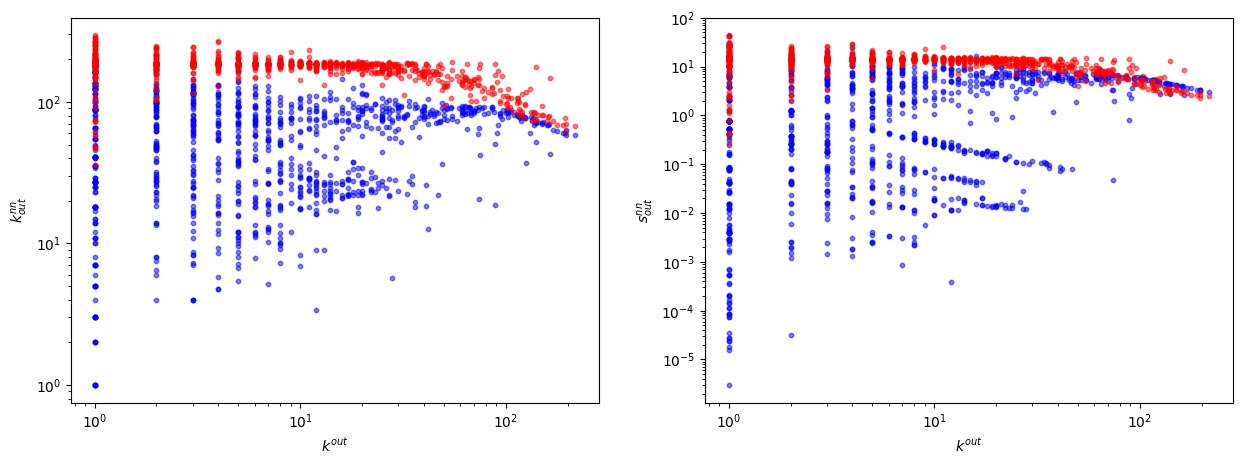

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_degrees, empirical_annd_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_degrees, exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k^{out}$", ylabel=r"$k^{nn}_{out}$", xscale="log", yscale="log")

ax2.scatter(out_degrees, empirical_anns_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_degrees, exp_anns_out, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k^{out}$", ylabel=r"$s^{nn}_{out}$", xscale="log", yscale="log")

In [134]:
# Average over all nodes with degree k
def average_property_over_degree(degrees, property_values, max_degree=None):
    if not max_degree:
        max_degree = np.max(degrees)+1
    averaged_values = np.zeros(max_degree)
    degree_hist = np.zeros(max_degree)
    for degree, property_value in zip(degrees, property_values):
        averaged_values[degree] += property_value
        degree_hist[degree] += 1
    averaged_values[degree_hist == 0] = np.nan
    degree_hist[degree_hist==0] = 1
    averaged_values = averaged_values/degree_hist
    return averaged_values

In [328]:
max_degree = max(np.max([graph.degree(mode="out") for graph in ensemble]), np.max(out_degrees)) + 1
empirical_annd_out_k = average_property_over_degree(out_degrees, empirical_annd_out, max_degree=max_degree)
ensemble_out_degrees = [graph.degree(mode="out") for graph in ensemble]
ensemble_annd = [network_properties.annd(graph, mode="out") for graph in tqdm(ensemble)]

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [00:29<00:00, 33.37it/s]


In [329]:
exp_annd_out_k = np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_annd[i], max_degree=max_degree) for i in tqdm(range(len(ensemble)))], axis=0)

100%|██████████| 1000/1000 [00:00<00:00, 2561.12it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_52208/1318081222.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_out_k = np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_annd[i], max_degree=max_degree) for i in tqdm(range(len(ensemble)))], axis=0)


Text(0, 0.5, '$k^{nn}_{out}$')

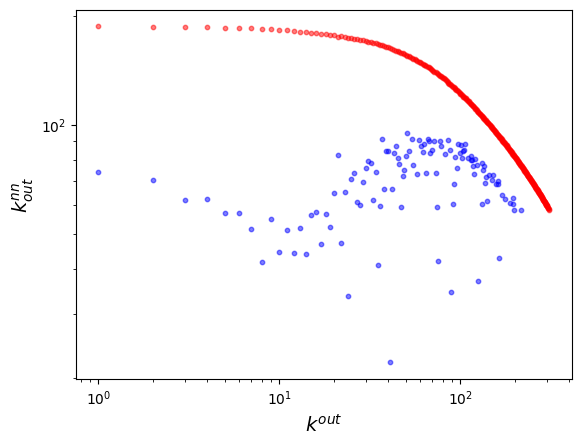

In [330]:
plt.scatter(range(max_degree), empirical_annd_out_k, s=10, c="blue", alpha=.5)
plt.scatter(range(max_degree), exp_annd_out_k, c="red", s=10, alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k^{out}$", fontsize=14)
plt.ylabel(r"$k^{nn}_{out}$", fontsize=14)


# ax2.scatter(out_degrees, empirical_annd_out, s=10, c="blue", alpha=.5)
# ax2.scatter(out_degrees, exp_anns_out, c="red", s=10, alpha=.5)
# ax2.set(xlabel=r"$k^{out}$", ylabel=r"$s^{nn}_{out}$", xscale="log", yscale="log")

### Local clustering coefficient

In [45]:
empirical_cl_coeff_out = network_properties.clustering_coeff(original_graph)

In [46]:
exp_cl_coeff = np.nanmean([network_properties.clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)

100%|██████████| 1000/1000 [00:07<00:00, 128.66it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_90744/2455847797.py:1: RuntimeWarning: Mean of empty slice
  exp_cl_coeff = np.nanmean([network_properties.clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)


NameError: name 'out_degrees' is not defined

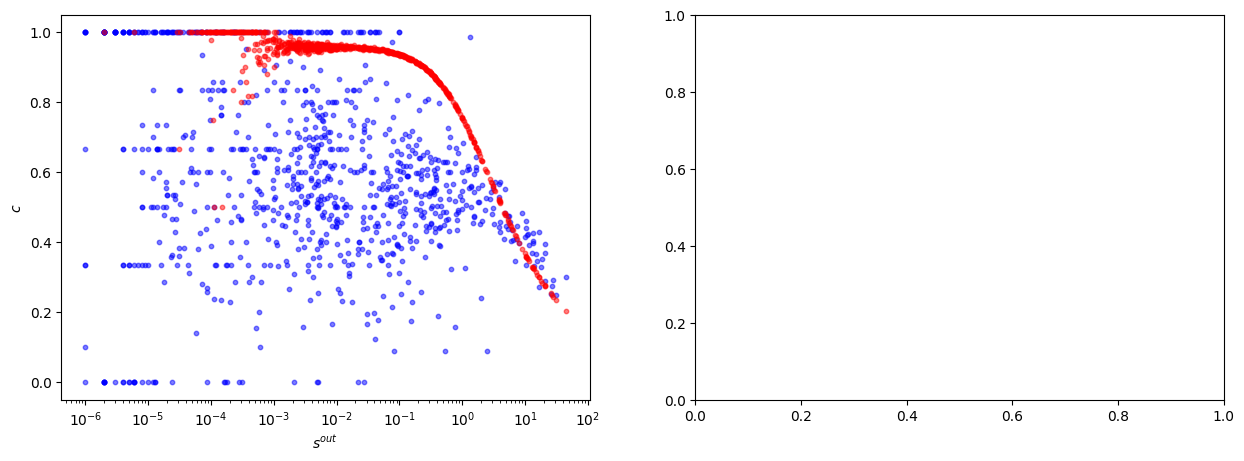

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$s^{out}$", ylabel=r"$c$", xscale="log")

ax2.scatter(out_degrees, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_degrees, exp_cl_coeff, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k^{out}$", ylabel=r"$c$", xscale="log")

In [ ]:
empirical_cl_coeff_k = average_property_over_degree(out_degrees, empirical_cl_coeff_out, max_degree=max_degree)
ensemble_cl_coeff = [network_properties.clustering_coeff(graph) for graph in tqdm(ensemble)]

100%|██████████| 1000/1000 [00:07<00:00, 127.01it/s]


In [ ]:
exp_cl_coeff_k= np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_cl_coeff[i], max_degree=max_degree) for i in tqdm(range(len(ensemble)))], axis=0)

100%|██████████| 1000/1000 [00:00<00:00, 2984.71it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_52208/3266902097.py:1: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k= np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_cl_coeff[i], max_degree=max_degree) for i in tqdm(range(len(ensemble)))], axis=0)


Text(0, 0.5, '$c$')

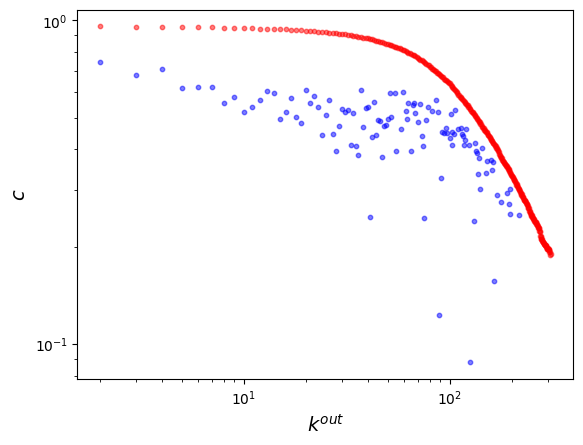

In [343]:
plt.scatter(range(max_degree), empirical_cl_coeff_k, s=10, c="blue", alpha=.5)
plt.scatter(range(max_degree), exp_cl_coeff_k, c="red", s=10, alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k^{out}$", fontsize=14)
plt.ylabel(r"$c$", fontsize=14)

Text(0, 0.5, '$c$')

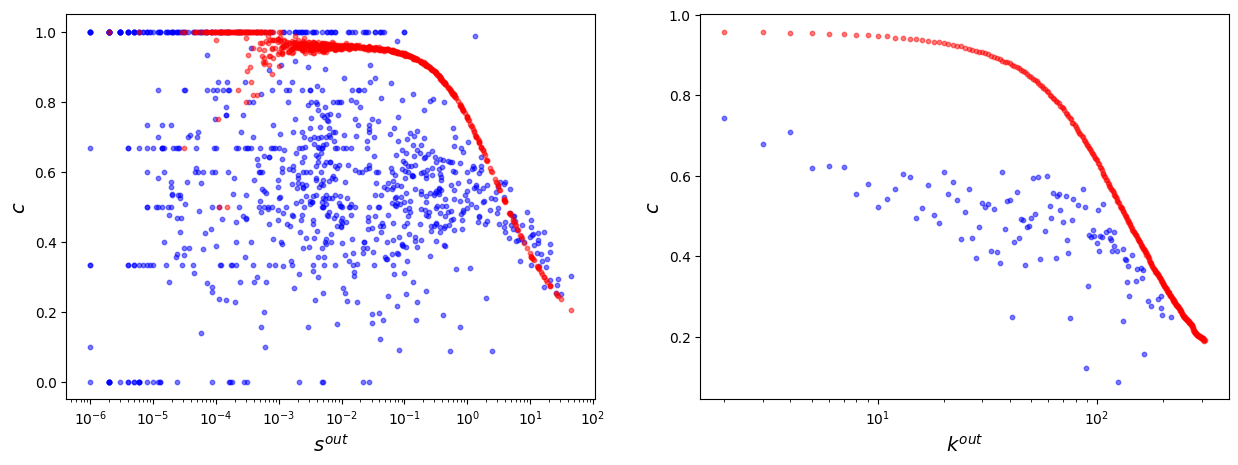

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xscale="log")
ax1.set_xlabel(r"$s^{out}$", fontsize=14)
ax1.set_ylabel(r"$c$", fontsize=14)

ax2.scatter(range(max_degree), empirical_cl_coeff_k, s=10, c="blue", alpha=.5)
ax2.scatter(range(max_degree), exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax2.set(xscale="log")
ax2.set_xlabel(r"$k^{out}$", fontsize=14)
ax2.set_ylabel(r"$c$", fontsize=14)

### Isolated nodes

In [141]:
avg_edges = np.mean([g.ecount() for g in ensemble])
print("Average number of edges, original model: ", avg_edges)

Average number of edges, original model:  19198.329


In [345]:
avg_max_degree = np.mean([max(g.degree()) for g in ensemble])
print("Average maximal degree, original model: ", avg_max_degree)

Average maximal degree, original model:  576.953


In [142]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in ensemble])
print("Average number of out-isolated nodes, original model: ", avg_degree_out)

Average number of out-isolated nodes, original model:  502.745


In [143]:
avg_degree_in = np.mean([g.degree(mode="in").count(0) for g in ensemble])
print("Average number of in-isolated nodes, original model: ", avg_degree_in)

Average number of in-isolated nodes, original model:  503.166


# Degree corrected models 

## Naive model

In [144]:
ensemble_size = 1000
method = renormalizable_model.create_naive_RM_graph
ensemble_naive = renormalizable_model.generate_RM_ensemble(method, ensemble_size, strengths, exp_z, weighted = True)

100%|██████████| 1000/1000 [02:30<00:00,  6.66it/s]


In [149]:
ensemble_size = 1000
ensemble_naive = renormalizable_model.NaiveRMEnsemble()
ensemble_naive.build_ensemble(ensemble_size, strengths, exp_z, filename="ensemble_niabe", weighted = True, parallel=False)

100%|██████████| 1000/1000 [18:55<00:00,  1.14s/it]


In [150]:
avg_edges = np.mean([g.ecount() for g in ensemble_naive])
print("Average number of edges, naive model: ", avg_edges)

Average number of edges, naive model:  19759.582


In [346]:
avg_max_degree = np.mean([max(g.degree()) for g in ensemble_naive])
print("Average maximal degree, original model: ", avg_max_degree)

Average maximal degree, original model:  611.876


In [151]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in ensemble_naive])
print("Average number of out-isolated nodes, naive model: ", avg_degree_out)

Average number of out-isolated nodes, naive model:  200.101


In [152]:
avg_degree_in = np.mean([g.degree(mode="in").count(0) for g in ensemble_naive])
print("Average number of in-isolated nodes, naive model: ", avg_degree_in)

Average number of in-isolated nodes, naive model:  502.384


## Correction of the naive model

In [9]:
def exp_num_of_links_corrected_naive(strengths, z):
    out_strengths = strengths[:,0]
    in_strengths = strengths[:,1]
    W = np.sum(out_strengths)
    num_nodes = len(out_strengths)
    prob_matrix = np.ones([num_nodes, num_nodes]) - np.exp(-z*out_strengths.reshape(num_nodes,1)@in_strengths.reshape(1,num_nodes))
    p_k_i_nonzero = 1/(1-np.exp(-z*out_strengths*W))
    p_k_i_nonzero_matrix = np.diag(p_k_i_nonzero)
    prob_matrix_k_nonzero = p_k_i_nonzero_matrix@prob_matrix
    return np.sum(prob_matrix_k_nonzero)

In [10]:
exp_z_details_corrected_naive = scipy.optimize.root_scalar(lambda z: exp_num_of_links_corrected_naive(strengths, z) - num_of_links, method="bisect", bracket=[0.001,1])
print(exp_z_details_corrected_naive)

      converged: True
           flag: converged
 function_calls: 41
     iterations: 39
           root: 0.2666026800226627


In [11]:
exp_z_corrected_naive = exp_z_details_corrected_naive.root

In [24]:
ensemble_size = 1000
ensemble_corrected_naive = renormalizable_model.CorrectedNaiveRMEnsemble()
ensemble_corrected_naive.build_ensemble(ensemble_size, strengths, exp_z_corrected_naive, filename="ensemble_corrected_naive", weighted = True, parallel=False)

100%|██████████| 1000/1000 [22:06<00:00,  1.33s/it]


In [25]:
avg_edges = np.mean([g.ecount() for g in ensemble_corrected_naive])
print("Average number of edges, original model: ", avg_edges)

Average number of edges, original model:  19195.15


In [29]:
avg_max_degree = np.mean([max(g.degree()) for g in ensemble_corrected_naive])
print("Average maximal degree, original model: ", avg_max_degree)

Average maximal degree, original model:  602.796


In [27]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in ensemble_corrected_naive])
print("Average number of out-isolated nodes, original model: ", avg_degree_out)

Average number of out-isolated nodes, original model:  0.0


In [28]:
avg_degree_in = np.mean([g.degree(mode="in").count(0) for g in ensemble_corrected_naive])
print("Average number of in-isolated nodes, original model: ", avg_degree_in)

Average number of in-isolated nodes, original model:  508.548


In [73]:
exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in tqdm(ensemble_corrected_naive)], axis=0)
exp_strengths_out = np.nanmean([graph.strength(mode="out", weights="weight") for graph in tqdm(ensemble_corrected_naive)], axis=0)

100%|██████████| 1000/1000 [00:06<00:00, 161.46it/s]


Text(0, 0.5, '$s^{out}$')

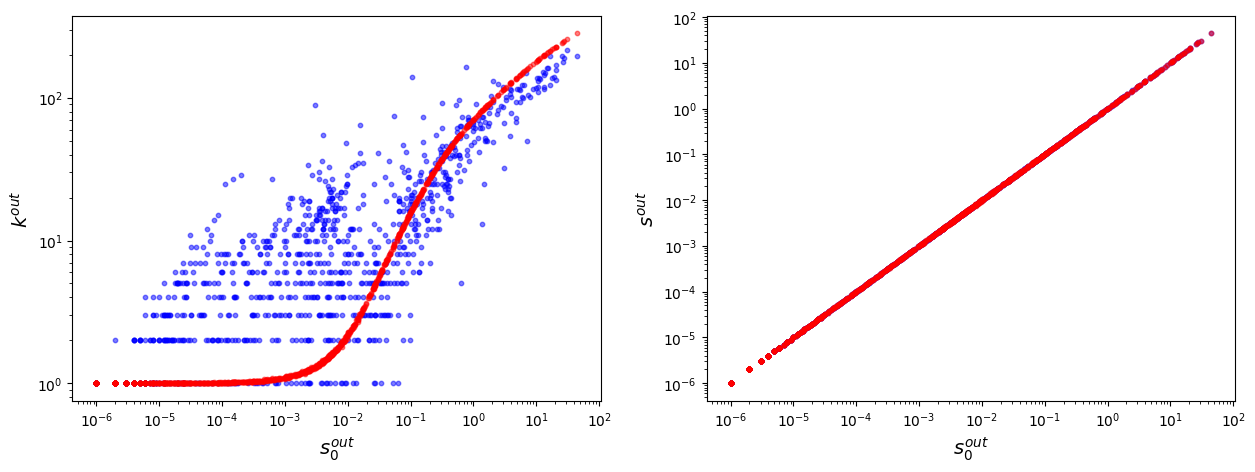

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")  
ax1.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{out}$", fontsize=14)

ax2.scatter(out_strengths, out_strengths, s=10, c="blue", alpha=.5)
ax2.scatter(out_strengths, exp_strengths_out, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax2.set_ylabel(r"$s^{out}$", fontsize=14)

In [67]:
exp_degrees_in = np.nanmean([graph.degree(mode="in") for graph in tqdm(ensemble_corrected_naive)], axis=0)
exp_strengths_in = np.nanmean([graph.strength(mode="in", weights="weight") for graph in tqdm(ensemble_corrected_naive)], axis=0)

100%|██████████| 1000/1000 [00:06<00:00, 154.09it/s]


Text(0, 0.5, '$s^{in}$')

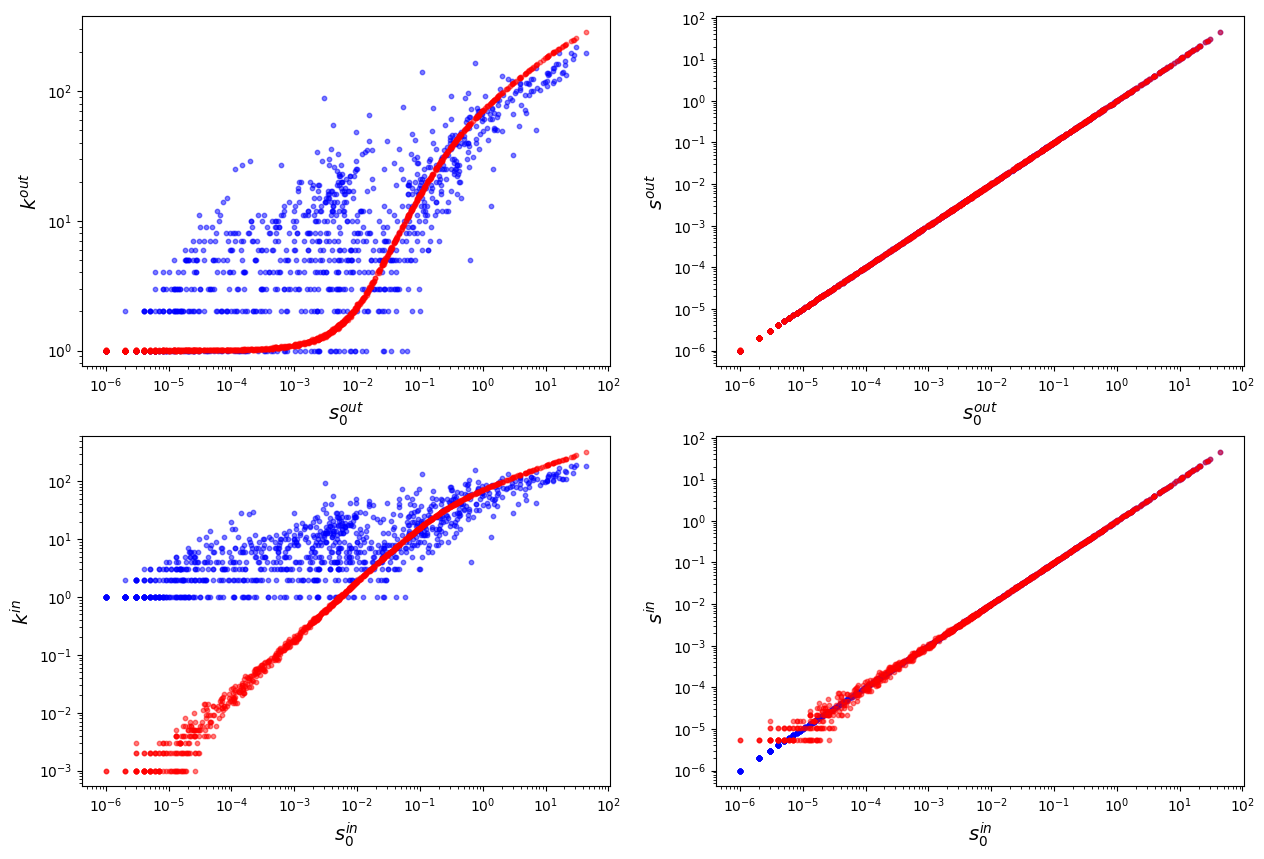

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].scatter(out_strengths, original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
axs[0,0].scatter(out_strengths, exp_degrees_out, c="red", s=10, alpha=.5)
axs[0,0].set(xscale="log", yscale="log")  
axs[0,0].set_xlabel(r"$s_0^{out}$", fontsize=14)
axs[0,0].set_ylabel(r"$k^{out}$", fontsize=14)

axs[0,1].scatter(out_strengths, out_strengths, s=10, c="blue", alpha=.5)
axs[0,1].scatter(out_strengths, exp_strengths_out, c="red", s=10, alpha=.5)
axs[0,1].set(xscale="log", yscale="log")
axs[0,1].set_xlabel(r"$s_0^{out}$", fontsize=14)
axs[0,1].set_ylabel(r"$s^{out}$", fontsize=14)

axs[1,0].scatter(in_strengths, original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
axs[1,0].scatter(in_strengths, exp_degrees_in, c="red", s=10, alpha=.5)
axs[1,0].set(xscale="log", yscale="log")  
axs[1,0].set_xlabel(r"$s_0^{in}$", fontsize=14)
axs[1,0].set_ylabel(r"$k^{in}$", fontsize=14)

axs[1,1].scatter(in_strengths, in_strengths, s=10, c="blue", alpha=.5)
axs[1,1].scatter(in_strengths, exp_strengths_in, c="red", s=10, alpha=.5)
axs[1,1].set(xscale="log", yscale="log")
axs[1,1].set_xlabel(r"$s_0^{in}$", fontsize=14)
axs[1,1].set_ylabel(r"$s^{in}$", fontsize=14)

In [34]:
max_degree = np.max([graph.degree() for graph in ensemble_corrected_naive])

degree_bins = np.logspace(0, np.log10(max_degree), 100)
degree_histograms_ensemble = [np.histogram(graph.degree(mode="out"), degree_bins)[0] for graph in ensemble_corrected_naive]
degree_histogram_empirical = np.histogram(original_graph.degree(mode="out"), degree_bins)[0]

degree_average_histogram = np.mean(degree_histograms_ensemble, axis=0)

In [38]:
all_strengths = np.array([graph.strength(weights="weight", mode="out") for graph in ensemble_corrected_naive])
max_strength = np.max(all_strengths)
min_strength = np.min(all_strengths[all_strengths>0])

strength_bins = np.logspace(np.log10(min_strength), np.log10(max_strength), 100)
strength_histograms_ensemble = [np.histogram(graph.strength(weights="weight", mode="out"), strength_bins)[0] for graph in ensemble_corrected_naive]
strength_histogram_empirical = np.histogram(out_strengths, strength_bins)[0]

strength_average_histogram = np.nanmean(strength_histograms_ensemble, axis=0)

Text(0, 0.5, 'Number of vertices')

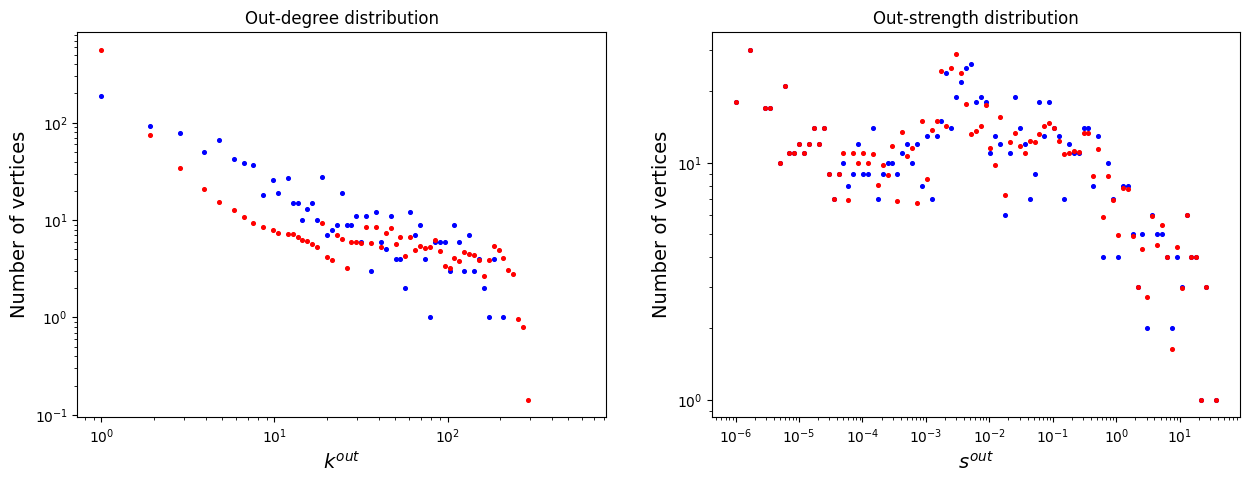

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(degree_bins[:-1], degree_histogram_empirical, s=7, color="blue")
ax1.scatter(degree_bins[:-1], degree_average_histogram, s=7, color="red")
ax1.set(xscale="log", yscale="log", title="Out-degree distribution")
ax1.set_xlabel("$k^{out}$", fontsize=14)
ax1.set_ylabel("Number of vertices", fontsize=14)

ax2.scatter(strength_bins[:-1], strength_histogram_empirical, s=7, color="blue")
ax2.scatter(strength_bins[:-1], strength_average_histogram, s=7, color="red")
ax2.set(xscale="log", yscale="log", title="Out-strength distribution")
ax2.set_xlabel("$s^{out}$", fontsize=14)
ax2.set_ylabel("Number of vertices", fontsize=14)


## Correction of out-degrees and in-degrees simultaneously

### z estimation

In [160]:
def bisect(bracket, num_of_links, initial_adj_matrix, precision, num_single_iter=1000000, ensemble_size=20000, skip_first=10000):
    z_min = bracket[0]
    z_max = bracket[1]
    if z_min > z_max:
        raise ValueError("invalid bracket, z_min > z_max")
    ensemble_min = renormalizable_model.DegreeCorrectedRMEnsemble(ensemble_size, strengths, z_min, initial_adj_matrix, "bisect", num_single_iter, skip_first=0)
    exp_num_links_min = np.mean([np.sum(utils.adj_matrix(graph)) for graph in ensemble_min[skip_first:]])
    ensemble_min.clear()
    ensemble_max = renormalizable_model.DegreeCorrectedRMEnsemble(ensemble_size, strengths, z_max, initial_adj_matrix, "bisect", num_single_iter, skip_first=0)
    exp_num_links_max = np.mean([np.sum(utils.adj_matrix(graph)) for graph in ensemble_max[skip_first:]])
    ensemble_max.clear()
    print("z:", z_min, "exp_num_links:", exp_num_links_min)
    print("z:", z_max, "exp_num_links:", exp_num_links_max)
    if np.sign(exp_num_links_min - num_of_links)*np.sign(exp_num_links_max - num_of_links) == 1:
        print("sign left:", np.sign(exp_num_links_min - num_of_links))
        print("sign right:", np.sign(exp_num_links_max - num_of_links))
        print("total sign:", np.sign(exp_num_links_min - num_of_links)*np.sign(exp_num_links_max - num_of_links))
        raise ValueError("Same sign on both sides of bracket")
    exp_num_links = 0
    i = 0
    while np.abs(exp_num_links - num_of_links) > precision:
        i+=1
        ratio = np.abs(exp_num_links_min - num_of_links)/np.abs(exp_num_links_max - num_of_links)
        z = z_min + (ratio/(1+ratio))*(z_max - z_min)
        # exp_num_links = np.mean(np.sum(get_fast_ensemble(initial_adj_matrix, strengths, z, num_single_iter, ensemble_size), axis=1))
        ensemble = renormalizable_model.DegreeCorrectedRMEnsemble(ensemble_size, strengths, z, initial_adj_matrix, "bisect", num_single_iter, skip_first=0)
        exp_num_links = np.mean([np.sum(utils.adj_matrix(graph)) for graph in ensemble[skip_first:]])
        ensemble.clear()
        if exp_num_links < num_of_links:
            z_min = z
            exp_num_links_min = exp_num_links
        else:
            z_max = z
            exp_num_links_max = exp_num_links
        # clear_output(wait=True)
        print("Iteration", i, "z:", z, "exp_num_links:", exp_num_links, "required_num_links:", num_of_links)
    return z

In [55]:
initial_adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.int8)
second_diagonal = np.diag_indices(num_nodes)
second_diagonal = (second_diagonal[0], (second_diagonal[1] + 1)%num_nodes)
initial_adj_matrix[second_diagonal] = 1
random_positions = np.random.randint(0, num_nodes, size=(num_of_links-num_nodes, 2))
initial_adj_matrix[random_positions[:,0], random_positions[:,1]] = 1

In [162]:
num_of_links = np.sum(weighted_adj_matrix > 0)

In [163]:
num_of_links

19199

In [164]:
num_nodes

1021

In [165]:
# z_corrected = bisect([0.2, 0.26], num_of_links, initial_adj_matrix, precision=1)

In [166]:
z_corrected = 0.2531750809758149

In [167]:
# import time
## current time in YYYYMMDD format
# now = time.strftime("%Y%m%d")
# ensemble_corrected = get_fast_ensemble(initial_adj_matrix, strengths, z_corrected, num_single_iter, ensemble_size, f"ensemble_corrected")

In [168]:
# num_single_iter_big = 1000000
# ensemble_size_big = 20000
# ensemble_corrected_big = get_fast_ensemble(initial_adj_matrix, strengths, z_corrected, num_single_iter_big, ensemble_size_big, f"ensemble_corrected_big", skip_first=0)

### Generating the ensemble

In [50]:
num_single_iter = 1000000
ensemble_size = 20000
ensemble_corrected_full = renormalizable_model.DegreeCorrectedRMEnsemble()
# ensemble_corrected_full.build_ensemble(ensemble_size, strengths, z_corrected, initial_adj_matrix, "ensemble_corrected_full", num_single_iter, skip_first=0)
ensemble_corrected_full.load_ensemble("ensemble_corrected_full")

In [51]:
edge_numbers = [graph.ecount() for graph in tqdm(ensemble_corrected_full)]
num_links_corrected_ensemble_full = np.mean(edge_numbers)

100%|██████████| 20000/20000 [02:01<00:00, 165.19it/s]


In [52]:
print("Average number of links in theb whole generated corrected ensemble:", num_links_corrected_ensemble_full)

Average number of links in theb whole generated corrected ensemble: 19182.14635


Text(0, 0.5, 'Number of links')

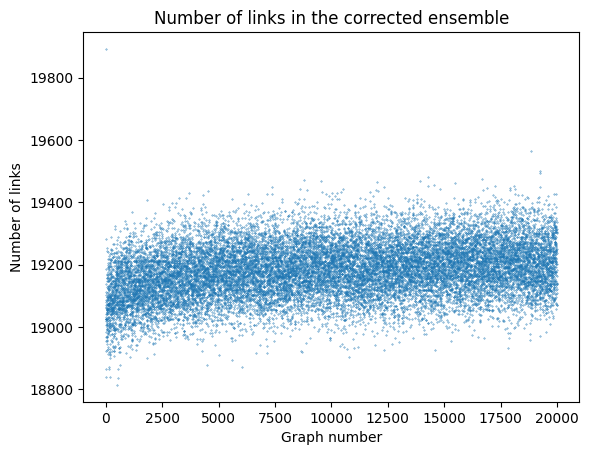

In [53]:
plt.scatter(range(len(edge_numbers)), edge_numbers, s=0.1)
plt.title("Number of links in the corrected ensemble")
plt.xlabel("Graph number")
plt.ylabel("Number of links")

Study, if second diagonal is preserved

In [56]:
preserved_edges_second_diagonal = [np.sum(utils.adj_matrix(graph)[second_diagonal] == 1) for graph in tqdm(ensemble_corrected_full)]

100%|██████████| 20000/20000 [21:20<00:00, 15.62it/s]


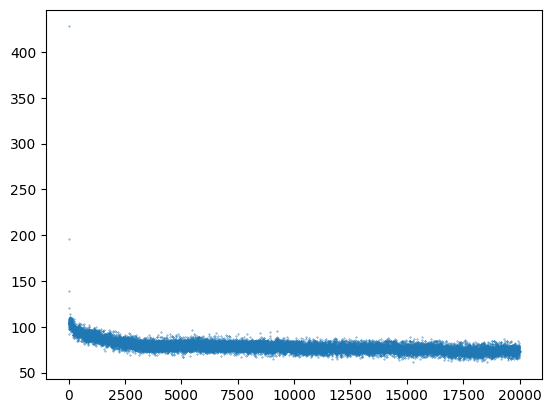

In [57]:
plt.scatter(range(ensemble_size), preserved_edges_second_diagonal, s=0.1)

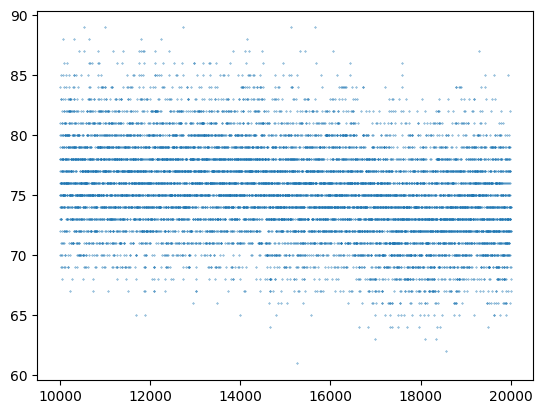

In [58]:
plt.scatter(range(10000, ensemble_size), preserved_edges_second_diagonal[10000:], s=0.1)

Text(0, 0.5, 'Number of preserved edges')

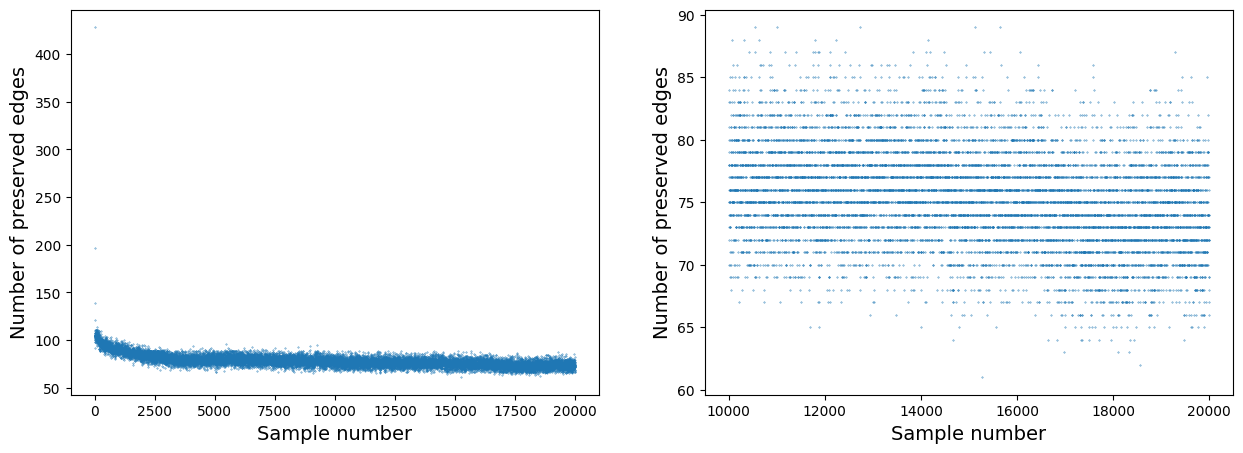

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(range(ensemble_size), preserved_edges_second_diagonal, s=0.1)
ax1.set_xlabel("Sample number", fontsize=14)
ax1.set_ylabel("Number of preserved edges", fontsize=14)

ax2.scatter(range(10000, ensemble_size), preserved_edges_second_diagonal[10000:], s=0.1)
ax2.set_xlabel("Sample number", fontsize=14)
ax2.set_ylabel("Number of preserved edges", fontsize=14)

In [221]:
avg_degree_out = np.mean([g.degree(mode="out").count(0) for g in tqdm(ensemble_corrected_full)])
print("Average number of out-isolated nodes, corrected model: ", avg_degree_out)
avg_degree_in = np.mean([g.degree(mode="in").count(0) for g in tqdm(ensemble_corrected_full)])
print("Average number of in-isolated nodes, corrected model: ", avg_degree_in)

100%|██████████| 20000/20000 [01:51<00:00, 179.85it/s]


Average number of out-isolated nodes, corrected model:  0.0


100%|██████████| 20000/20000 [01:50<00:00, 180.20it/s]

Average number of in-isolated nodes, corrected model:  0.0


In [60]:
ensemble_corrected_no_weights = renormalizable_model.DegreeCorrectedRMEnsemble()
# renormalizable_model.make_ensemble_from_subset(ensemble_new=ensemble_corrected_no_weights, filename_new="ensemble_corrected_no_weights", ensemble_old=ensemble_corrected_full, index_start=10000, index_end=20000)
ensemble_corrected_no_weights.load_ensemble("ensemble_corrected_no_weights")

File already exists, deleting


100%|██████████| 10000/10000 [04:40<00:00, 35.63it/s]


### Asigning weights

In [61]:
def compute_average_prob_matrix(ensemble, index_range):
    sum_matrix = np.zeros([ensemble[0].vcount(), ensemble[0].vcount()])
    for i in tqdm(index_range):
        sum_matrix += utils.adj_matrix(ensemble[i])
    return sum_matrix/len(list(index_range))

In [282]:
avg_prob_matrix = compute_average_prob_matrix(ensemble_corrected_full, range(10000,20000))

100%|██████████| 10000/10000 [09:59<00:00, 16.67it/s]


In [283]:
edge_numbers = [graph.ecount() for graph in tqdm(ensemble_corrected_no_weights)]
num_links_corrected_ensemble = np.mean(edge_numbers)

100%|██████████| 10000/10000 [00:47<00:00, 211.54it/s]


In [284]:
print("Average number of links in corrected ensemble:", num_links_corrected_ensemble)

Average number of links in corrected ensemble: 19200.0995


In [11]:
ensemble_corrected = renormalizable_model.DegreeCorrectedRMEnsembleWeighted()
# ensemble_corrected.build_ensemble(ensemble_corrected_no_weights, strengths, avg_prob_matrix, f"ensemble_corrected")
ensemble_corrected.load_ensemble("ensemble_corrected")

### Comparison of network properties

#### Degrees and strengths

Node by node

In [75]:
exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in tqdm(ensemble_corrected)], axis=0)
exp_strengths_out = np.nanmean([graph.strength(mode="out", weights="weight") for graph in tqdm(ensemble_corrected)], axis=0)
exp_degrees_in = np.nanmean([graph.degree(mode="in") for graph in tqdm(ensemble_corrected)], axis=0)
exp_strengths_in = np.nanmean([graph.strength(mode="in", weights="weight") for graph in tqdm(ensemble_corrected)], axis=0)

100%|██████████| 10000/10000 [01:02<00:00, 159.56it/s]


Text(0, 0.5, '$s^{out}$')

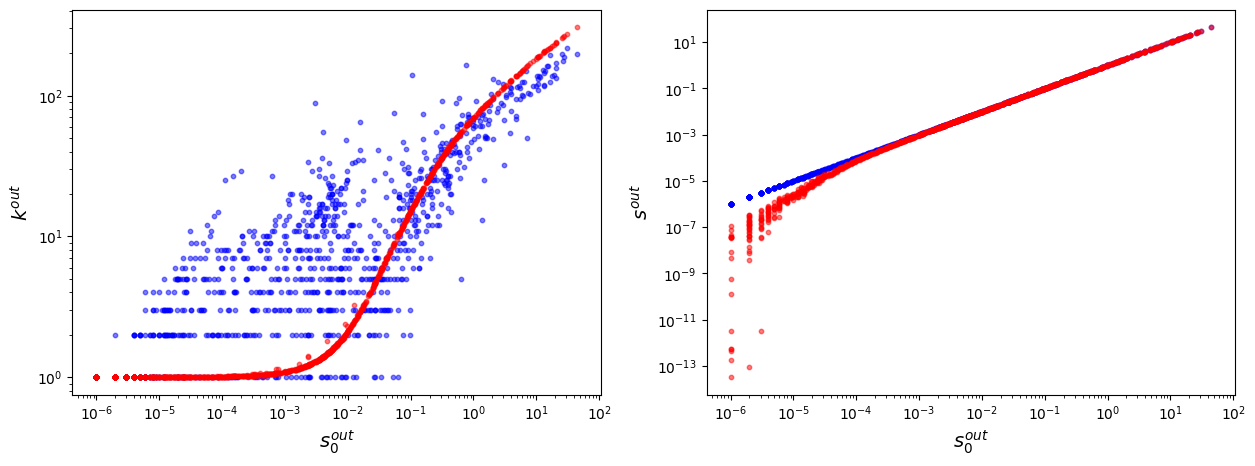

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")  
ax1.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{out}$", fontsize=14)

ax2.scatter(out_strengths, out_strengths, s=10, c="blue", alpha=.5)
ax2.scatter(out_strengths, exp_strengths_out, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$s_0^{out}$", fontsize=14)
ax2.set_ylabel(r"$s^{out}$", fontsize=14)

Text(0, 0.5, '$s^{in}$')

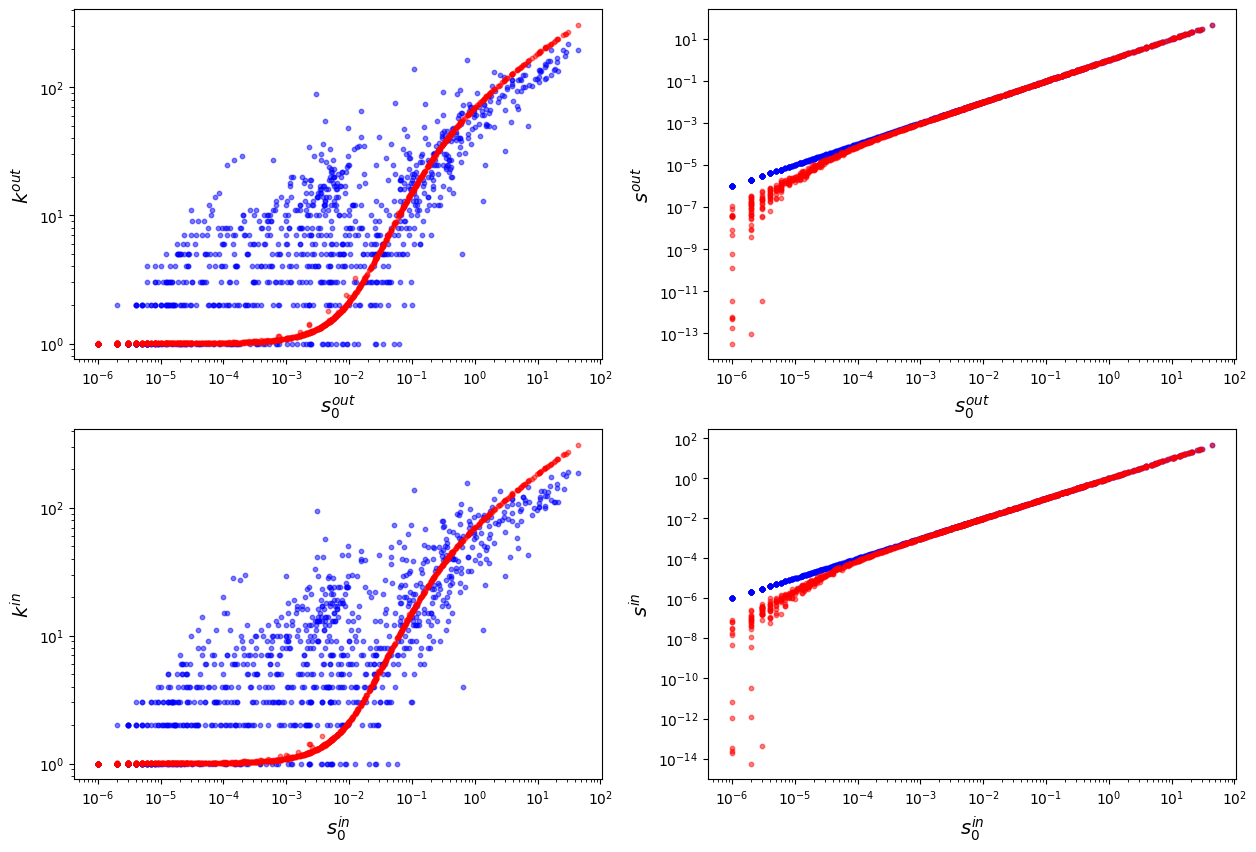

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].scatter(out_strengths, original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
axs[0,0].scatter(out_strengths, exp_degrees_out, c="red", s=10, alpha=.5)
axs[0,0].set(xscale="log", yscale="log")  
axs[0,0].set_xlabel(r"$s_0^{out}$", fontsize=14)
axs[0,0].set_ylabel(r"$k^{out}$", fontsize=14)

axs[0,1].scatter(out_strengths, out_strengths, s=10, c="blue", alpha=.5)
axs[0,1].scatter(out_strengths, exp_strengths_out, c="red", s=10, alpha=.5)
axs[0,1].set(xscale="log", yscale="log")
axs[0,1].set_xlabel(r"$s_0^{out}$", fontsize=14)
axs[0,1].set_ylabel(r"$s^{out}$", fontsize=14)

axs[1,0].scatter(in_strengths, original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
axs[1,0].scatter(in_strengths, exp_degrees_in, c="red", s=10, alpha=.5)
axs[1,0].set(xscale="log", yscale="log")  
axs[1,0].set_xlabel(r"$s_0^{in}$", fontsize=14)
axs[1,0].set_ylabel(r"$k^{in}$", fontsize=14)

axs[1,1].scatter(in_strengths, in_strengths, s=10, c="blue", alpha=.5)
axs[1,1].scatter(in_strengths, exp_strengths_in, c="red", s=10, alpha=.5)
axs[1,1].set(xscale="log", yscale="log")
axs[1,1].set_xlabel(r"$s_0^{in}$", fontsize=14)
axs[1,1].set_ylabel(r"$s^{in}$", fontsize=14)

Histograms

In [288]:
max_degree = np.max([graph.degree() for graph in ensemble_corrected])

degree_bins = np.logspace(0, np.log10(max_degree), 100)
degree_histograms_ensemble = [np.histogram(graph.degree(mode="out"), degree_bins)[0] for graph in ensemble_corrected]
degree_histogram_empirical = np.histogram(original_graph.degree(mode="out"), degree_bins)[0]

degree_average_histogram = np.mean(degree_histograms_ensemble, axis=0)

In [290]:
all_strengths = np.array([graph.strength(weights="weight", mode="out") for graph in ensemble_corrected])
max_strength = np.max(all_strengths)
min_strength = np.min(all_strengths[all_strengths>0])

strength_bins = np.logspace(np.log10(min_strength), np.log10(max_strength), 100)
strength_histograms_ensemble = [np.histogram(graph.strength(weights="weight", mode="out"), strength_bins)[0] for graph in ensemble_corrected]
strength_histogram_empirical = np.histogram(out_strengths, strength_bins)[0]

strength_average_histogram = np.nanmean(strength_histograms_ensemble, axis=0)

[None,
 None,
 Text(0.5, 0, '$s^{out}$'),
 Text(0, 0.5, 'Number of vertices'),
 Text(0.5, 1.0, 'Out-strength distribution')]

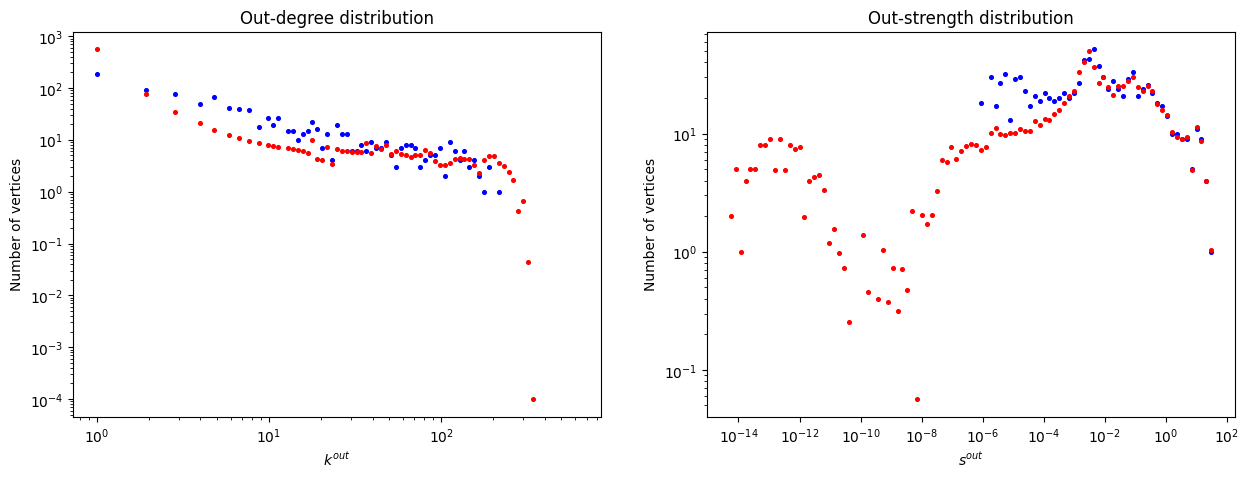

In [291]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(degree_bins[:-1], degree_histogram_empirical, s=7, c="blue")
ax1.scatter(degree_bins[:-1], degree_average_histogram, s=7, c="red")
ax1.set(xscale="log", yscale="log", xlabel="$k^{out}$", ylabel="Number of vertices", title="Out-degree distribution")

ax2.scatter(strength_bins[:-1], strength_histogram_empirical, s=7, c="blue")
ax2.scatter(strength_bins[:-1], strength_average_histogram, s=7, c="red")
ax2.set(xscale="log", yscale="log", xlabel="$s^{out}$", ylabel="Number of vertices", title="Out-strength distribution")


### ANND and ANNS

In [12]:
empirical_annd_out = network_properties.annd(original_graph, mode="out")
empirical_anns_out = network_properties.anns(original_graph, mode="out")

In [17]:
ensemble_annd = [network_properties.annd(graph, mode="out") for graph in tqdm(ensemble_corrected)]
exp_annd_out = np.nanmean(ensemble_annd, axis=0)

  7%|▋         | 728/10000 [00:21<04:25, 34.89it/s]/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10000/10000 [04:46<00:00, 34.94it/s]


In [42]:
exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble_corrected)], axis=0)

100%|██████████| 10000/10000 [34:13<00:00,  4.87it/s]


Text(0, 0.5, '$s^{nn}_{out}$')

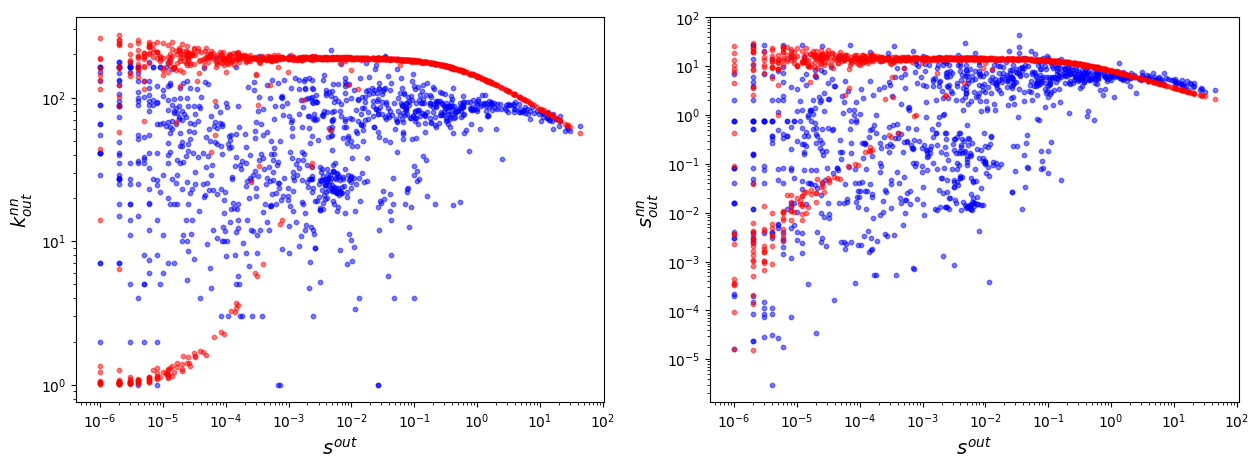

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_annd_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")
ax1.set_xlabel(r"$s^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{nn}_{out}$", fontsize=14)

ax2.scatter(out_strengths, empirical_anns_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_strengths, exp_anns_out, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$s^{out}$", fontsize=14)
ax2.set_ylabel(r"$s^{nn}_{out}$", fontsize=14)

In [69]:
np.where(exp_annd_out < 1.05)

(array([  37,   41,   42,  291,  294,  451,  566,  603,  626,  630,  633,
         774,  792,  793,  835,  858,  876,  894,  901,  905,  948,  950,
         951,  956,  975,  989,  992,  994, 1000, 1018]),)

In [63]:
g = ensemble_corrected[5000]

In [71]:
g.vs[41].neighbors()

[igraph.Vertex(<igraph.Graph object at 0x2bf023e50>, 42, {}),
 igraph.Vertex(<igraph.Graph object at 0x2bf023e50>, 294, {})]

In [45]:
out_degrees = original_graph.degree(mode="out")

[Text(0.5, 0, '$k^{out}$'), Text(0, 0.5, '$s^{nn}_{out}$'), None, None]

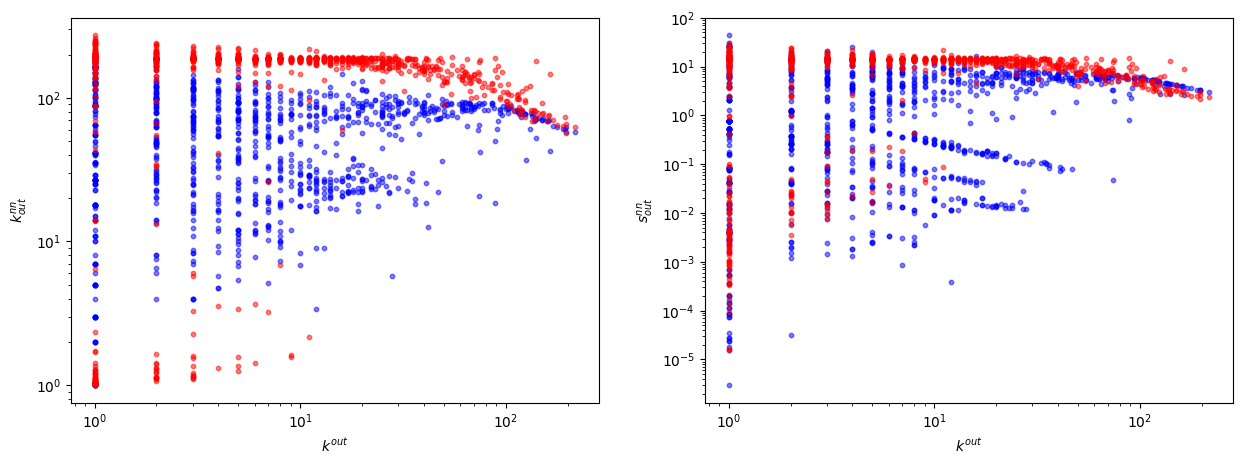

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_degrees, empirical_annd_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_degrees, exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k^{out}$", ylabel=r"$k^{nn}_{out}$", xscale="log", yscale="log")

ax2.scatter(out_degrees, empirical_anns_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_degrees, exp_anns_out, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k^{out}$", ylabel=r"$s^{nn}_{out}$", xscale="log", yscale="log")

In [43]:
# Average over all nodes with degree k
def average_property_over_degree(degrees, property_values, max_degree=None):
    if not max_degree:
        max_degree = np.max(degrees)+1
    averaged_values = np.zeros(max_degree)
    degree_hist = np.zeros(max_degree)
    for degree, property_value in zip(degrees, property_values):
        averaged_values[degree] += property_value
        degree_hist[degree] += 1
    averaged_values[degree_hist == 0] = np.nan
    degree_hist[degree_hist==0] = 1
    averaged_values = averaged_values/degree_hist
    return averaged_values

In [46]:
max_degree = max(np.max([graph.degree(mode="out") for graph in ensemble_corrected]), np.max(out_degrees)) + 1
empirical_annd_out_k = average_property_over_degree(out_degrees, empirical_annd_out, max_degree=max_degree)
ensemble_out_degrees = [graph.degree(mode="out") for graph in ensemble_corrected]

In [47]:
exp_annd_out_k = np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_annd[i], max_degree=max_degree) for i in tqdm(range(len(ensemble_corrected)))], axis=0)

100%|██████████| 10000/10000 [00:03<00:00, 2738.44it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_1663/3718299256.py:1: RuntimeWarning: Mean of empty slice
  exp_annd_out_k = np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_annd[i], max_degree=max_degree) for i in tqdm(range(len(ensemble_corrected)))], axis=0)


Text(0, 0.5, '$k^{nn}_{out}$')

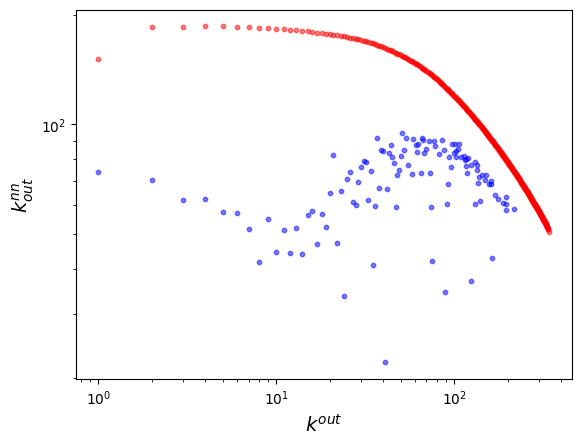

In [48]:
plt.scatter(range(max_degree), empirical_annd_out_k, s=10, c="blue", alpha=.5)
plt.scatter(range(max_degree), exp_annd_out_k, c="red", s=10, alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k^{out}$", fontsize=14)
plt.ylabel(r"$k^{nn}_{out}$", fontsize=14)


# ax2.scatter(out_degrees, empirical_annd_out, s=10, c="blue", alpha=.5)
# ax2.scatter(out_degrees, exp_anns_out, c="red", s=10, alpha=.5)
# ax2.set(xlabel=r"$k^{out}$", ylabel=r"$s^{nn}_{out}$", xscale="log", yscale="log")

### Local clustering coefficient

In [49]:
empirical_cl_coeff_out = network_properties.clustering_coeff(original_graph)

In [50]:
exp_cl_coeff = np.nanmean([network_properties.clustering_coeff(graph) for graph in tqdm(ensemble_corrected)], axis=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:16<00:00, 131.09it/s]


Text(0, 0.5, '$c$')

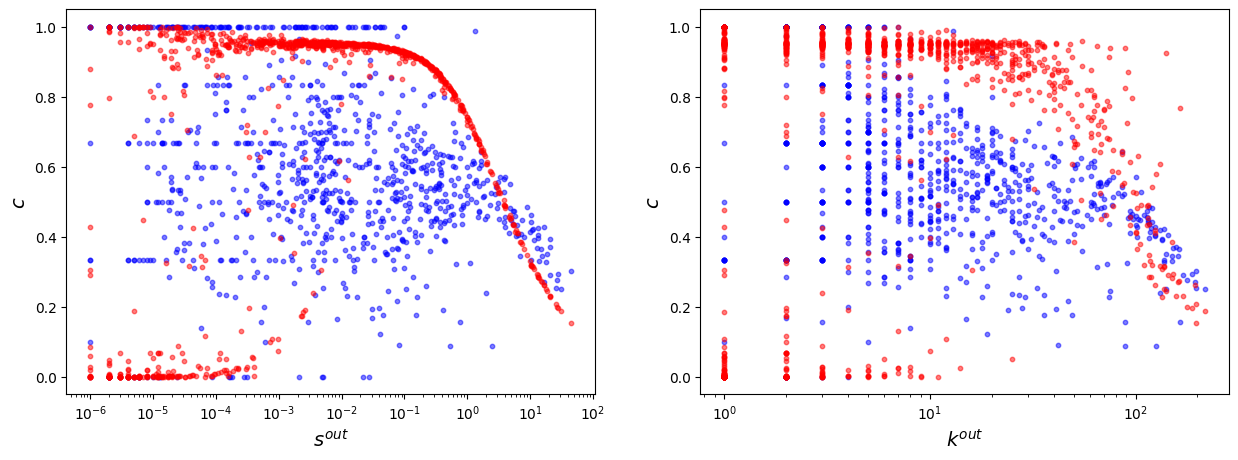

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xscale="log")
ax1.set_xlabel(r"$s^{out}$", fontsize=14)
ax1.set_ylabel(r"$c$", fontsize=14)

ax2.scatter(out_degrees, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_degrees, exp_cl_coeff, c="red", s=10, alpha=.5)
ax2.set(xscale="log")
ax2.set_xlabel(r"$k^{out}$", fontsize=14)
ax2.set_ylabel(r"$c$", fontsize=14)

In [52]:
cl_coeff_single = network_properties.clustering_coeff(ensemble_corrected[0])

[Text(0.5, 0, '$k^{out}$'), Text(0, 0.5, '$c$'), None]

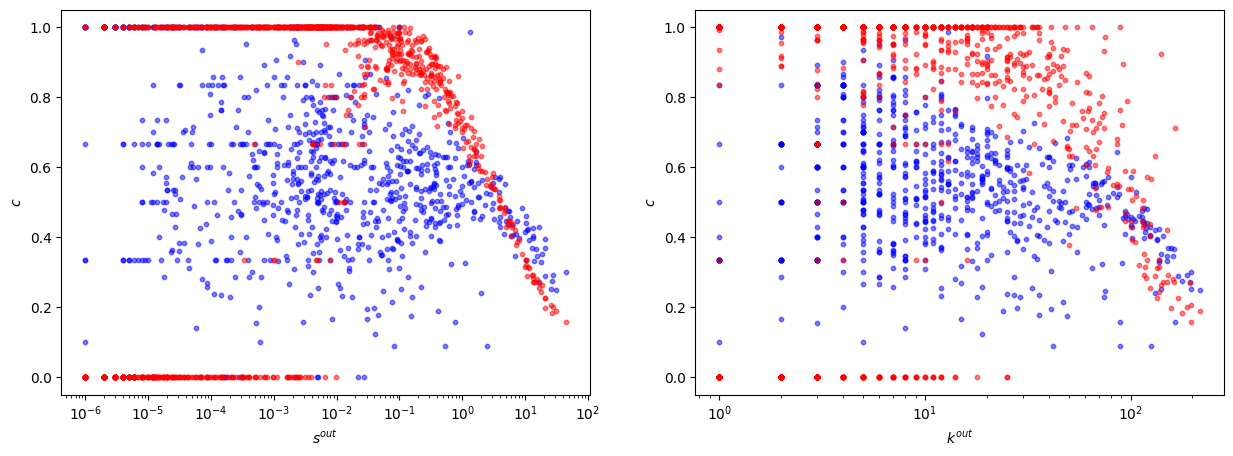

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(out_strengths, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax1.scatter(out_strengths, cl_coeff_single, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$s^{out}$", ylabel=r"$c$", xscale="log")

ax2.scatter(out_degrees, empirical_cl_coeff_out, s=10, c="blue", alpha=.5)
ax2.scatter(out_degrees, cl_coeff_single, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k^{out}$", ylabel=r"$c$", xscale="log")

In [54]:
empirical_cl_coeff_k = average_property_over_degree(out_degrees, empirical_cl_coeff_out, max_degree=max_degree)
ensemble_cl_coeff = [network_properties.clustering_coeff(graph) for graph in tqdm(ensemble_corrected)]

100%|██████████| 10000/10000 [01:16<00:00, 131.31it/s]


In [55]:
exp_cl_coeff_k= np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_cl_coeff[i], max_degree=max_degree) for i in tqdm(range(len(ensemble_corrected)))], axis=0)

100%|██████████| 10000/10000 [00:03<00:00, 3091.69it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_1663/1037513373.py:1: RuntimeWarning: Mean of empty slice
  exp_cl_coeff_k= np.nanmean([average_property_over_degree(ensemble_out_degrees[i], ensemble_cl_coeff[i], max_degree=max_degree) for i in tqdm(range(len(ensemble_corrected)))], axis=0)


Text(0, 0.5, '$c$')

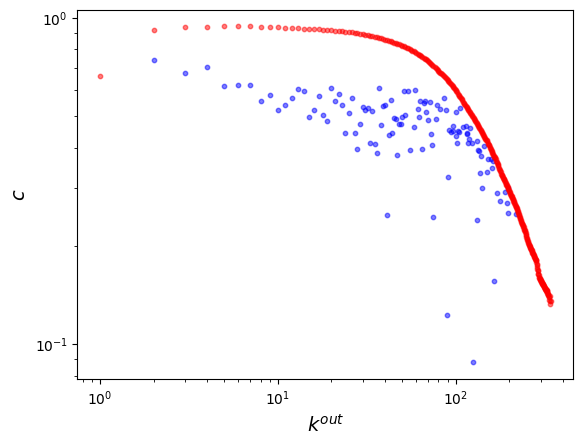

In [56]:
plt.scatter(range(max_degree), empirical_cl_coeff_k, s=10, c="blue", alpha=.5)
plt.scatter(range(max_degree), exp_cl_coeff_k, c="red", s=10, alpha=.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k^{out}$", fontsize=14)
plt.ylabel(r"$c$", fontsize=14)


Text(0, 0.5, '$c$')

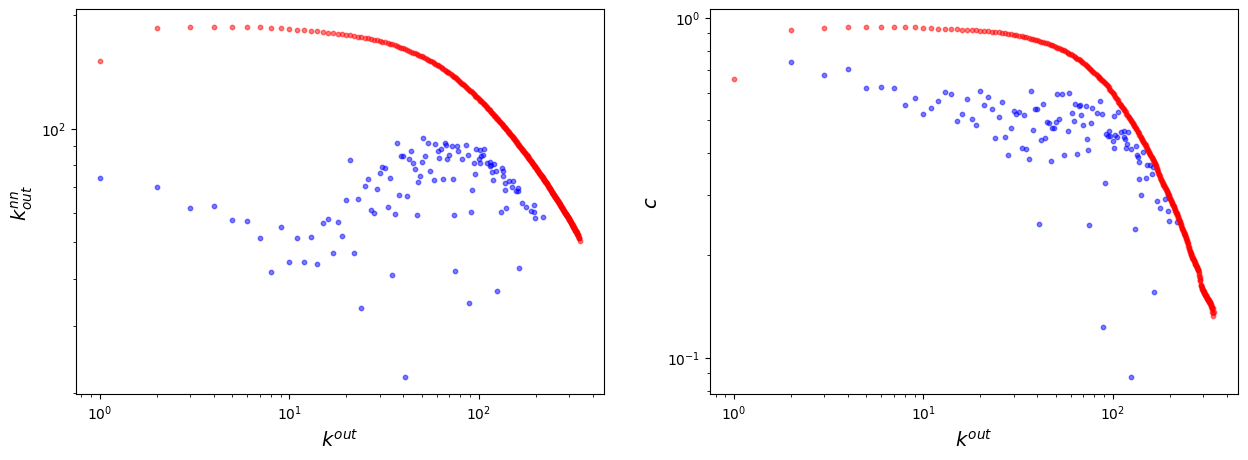

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(range(max_degree), empirical_annd_out_k, s=10, c="blue", alpha=.5)
ax1.scatter(range(max_degree), exp_annd_out_k, c="red", s=10, alpha=.5)
ax1.set(xscale="log", yscale="log")
ax1.set_xlabel(r"$k^{out}$", fontsize=14)
ax1.set_ylabel(r"$k^{nn}_{out}$", fontsize=14)

ax2.scatter(range(max_degree), empirical_cl_coeff_k, s=10, c="blue", alpha=.5)
ax2.scatter(range(max_degree), exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax2.set(xscale="log", yscale="log")
ax2.set_xlabel(r"$k^{out}$", fontsize=14)
ax2.set_ylabel(r"$c$", fontsize=14)

Text(0, 0.5, '$c$')

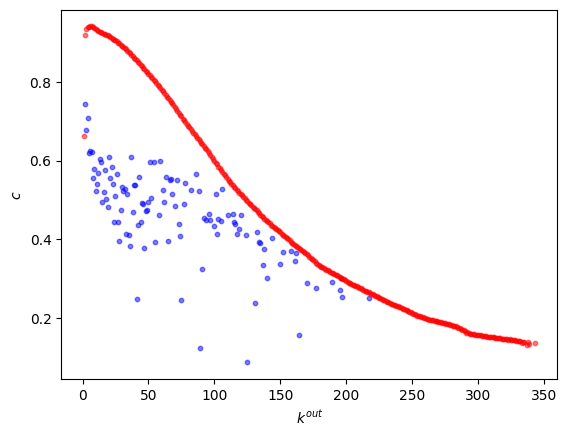

In [57]:
plt.scatter(range(max_degree), empirical_cl_coeff_k, s=10, c="blue", alpha=.5)
plt.scatter(range(max_degree), exp_cl_coeff_k, c="red", s=10, alpha=.5)
plt.xlabel(r"$k^{out}$")
plt.ylabel(r"$c$")
